# Agriculture Crop Yield: Predict Fertilizer Use

By: Jaeyoung Oh

GitHub: https://github.com/BlueJayVRStudio/CSCA5632_final



##### dataset: https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield

The author of the dataset also posted a preliminary EDA. We will use this as a reference and adjust it to the needs of this project

##### EDA reference: https://www.kaggle.com/code/samuelotiattakorah/eda-on-agriculture-crop-yield

## Initial Project Setup

In [435]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from helpers.metrics import *

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

In [436]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA

In [437]:
num_tests = 5
tests_passed = 0

In [438]:
# import data
df_crop_yield = pd.read_csv('./data/crop_yield.csv')

### Data Description

In [439]:
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


There are **no null values**, so conveniently we do not have to fill in any missing values. However, we still have numerous preprocessing steps to ensure that our data is ready for clustering tasks.
> - Separate "Fertilizer_Used" from rest of the data frame since we'll be using that as target class,
> - "Region", "Soil_Type" and "Crop" are non-ordinal categorical data, thus we need to convert them to binary, one-hot encoding,
> - "Weather_Condition" is also categorical, but one could argue that it is ordinal since cloud cover is directly proportional to sunlight and precipitation. Using just one of those two relationships should suffice,
> - For the rest of the numerical columns, we will perform quick outlier analysis and drop them as we have sufficient data. We will also ensure that no column has over-influence by using standard scaling,
> - Random sample portion of the dataset, since we will run into memory issues with 1 million data points,
> - Lastly we will check for class imbalance on fertilizer use to ensure that we are working with a balanced sample dataset.

In [440]:
df_crop_yield.head(10)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
5,South,Silt,Soybean,797.471182,37.704974,False,True,Rainy,74,5.898416
6,West,Clay,Wheat,357.902357,31.593431,False,False,Rainy,90,2.652392
7,South,Sandy,Rice,441.131154,30.887107,True,True,Sunny,61,5.829542
8,North,Silt,Wheat,181.587861,26.752729,True,False,Sunny,127,2.943716
9,West,Sandy,Wheat,395.048968,17.646199,False,True,Rainy,140,3.707293


In [441]:
# Sanity Check 1: Check unprocessed crop yield dataframe shape
assert df_crop_yield.shape == (1000000, 10), f"expected (1000000, 10), but got {df_crop_yield.shape}"
tests_passed += 1
print ("1. Tests Passed")

1. Tests Passed


### One-hot encode Region, Soil Type, and Crop

In [442]:
df_crop_yield = pd.get_dummies(df_crop_yield, columns =['Region', 'Soil_Type', 'Crop'])
# confirm one-hot encoding for region and crop 
df_crop_yield

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
0,897.077239,27.676966,False,True,Cloudy,122,6.555816,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,992.673282,18.026142,True,True,Rainy,140,8.527341,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,147.998025,29.794042,False,False,Sunny,106,1.127443,False,True,False,...,True,False,False,False,True,False,False,False,False,False
3,986.866331,16.644190,False,True,Rainy,146,6.517573,False,True,False,...,False,False,True,False,False,False,False,False,True,False
4,730.379174,31.620687,True,True,Cloudy,110,7.248251,False,False,True,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,302.805345,27.987428,False,False,Sunny,76,1.347586,False,False,False,...,False,False,False,True,False,False,False,True,False,False
999996,932.991383,39.661039,True,False,Rainy,93,7.311594,False,False,True,...,False,False,False,False,True,False,False,False,False,False
999997,867.362046,24.370042,True,False,Cloudy,108,5.763182,False,True,False,...,False,True,False,False,False,True,False,False,False,False
999998,492.812857,33.045505,False,False,Sunny,102,2.070159,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [443]:
# Sanity Check 2: Check one-hot encoded crop yield dataframe shape
assert df_crop_yield.shape == (1000000, 23), f"expected (1000000, 23), but got {df_crop_yield.shape}"
tests_passed += 1
print ("2. Tests Passed")

2. Tests Passed


### Convert Weather Condition to Ordinal Ranking

In [444]:
print(df_crop_yield.Weather_Condition.unique())

['Cloudy' 'Rainy' 'Sunny']


In [445]:
weather_ranking = {'Rainy': 0, 'Cloudy': 1, 'Sunny': 2}

In [446]:
df_crop_yield['Weather_Condition'] = df_crop_yield['Weather_Condition'].map(weather_ranking)

In [447]:
# Sanity Check 3: Repeat previous checks and check data type of weather condition
assert df_crop_yield.shape == (1000000, 23 ), f"expected (1000000, 23 ), but got {df_crop_yield.shape}"
assert df_crop_yield.Weather_Condition.dtype == np.int64, "Weather condition not converted to ordinal ranking"
tests_passed += 1
print ("3. Tests Passed")

3. Tests Passed


### Outlier Analysis and Miscellaneous Cleaning on Numerical Data

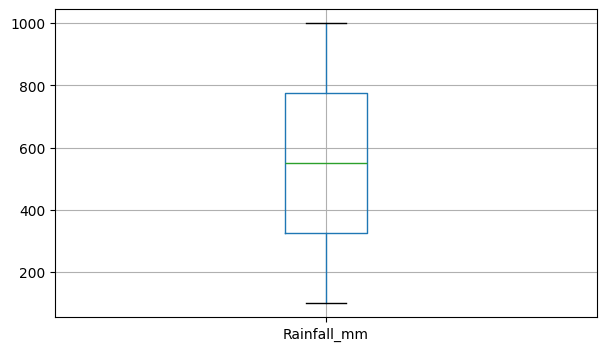

In [448]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Rainfall_mm']].boxplot()
plt.xticks(rotation=0)
plt.show()

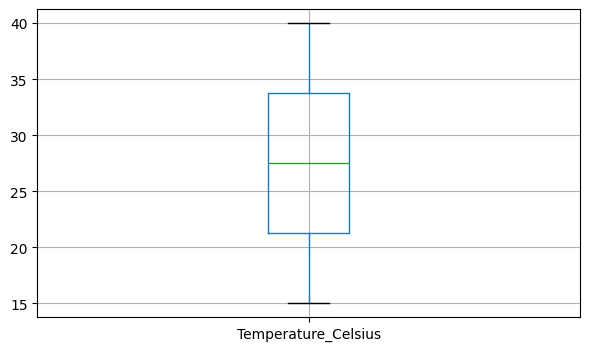

In [449]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Temperature_Celsius']].boxplot()
plt.xticks(rotation=0)
plt.show()

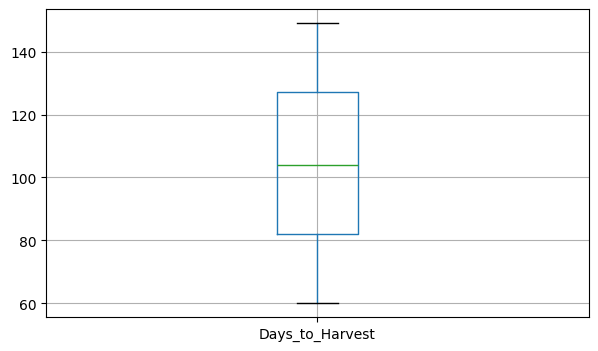

In [450]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Days_to_Harvest']].boxplot()
plt.xticks(rotation=0)
plt.show()

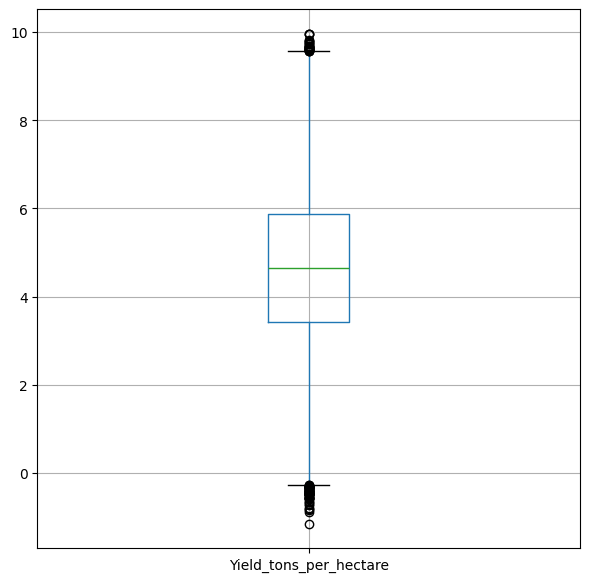

In [451]:
plt.figure(figsize=(7, 7))
df_crop_yield[['Yield_tons_per_hectare']].boxplot()
plt.xticks(rotation=0)
plt.show()

In [452]:
Q1 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.25)
Q3 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < lower_bound) | (df_crop_yield['Yield_tons_per_hectare'] > upper_bound)]
outliers

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
11596,957.380991,36.324216,True,True,2,73,9.727004,False,False,False,...,False,True,False,False,False,False,False,False,False,True
39669,147.755191,20.390486,False,False,1,72,-0.469229,True,False,False,...,True,False,False,False,True,False,False,False,False,False
54745,119.136310,15.984143,False,False,1,93,-0.290180,False,True,False,...,False,True,False,False,True,False,False,False,False,False
77504,120.422223,22.809881,False,False,0,120,-0.841617,False,False,False,...,False,False,True,False,False,False,False,False,False,True
93760,108.811480,17.936402,False,False,0,88,-0.434482,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942403,987.281001,23.821032,True,True,0,114,9.826285,False,False,True,...,False,False,False,True,False,False,True,False,False,False
947118,110.727929,23.191667,False,False,0,80,-0.507013,False,True,False,...,False,False,False,False,False,True,False,False,False,False
949892,107.476604,15.473496,False,False,2,80,-0.309650,False,True,False,...,False,False,False,True,False,False,False,False,True,False
966078,948.730680,38.383078,True,True,1,82,9.650875,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [453]:
negatives = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < 0)]
negatives

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
756,101.019421,33.804131,False,False,0,117,-0.007103,True,False,False,...,False,True,False,False,False,True,False,False,False,False
7799,108.804894,18.004082,False,False,2,86,-0.061283,False,False,True,...,False,False,False,False,False,False,False,True,False,False
8421,168.120735,38.473430,False,False,1,111,-0.119911,True,False,False,...,False,False,False,False,False,False,False,False,True,False
9553,156.607973,16.610257,False,False,2,129,-0.193093,False,True,False,...,False,False,False,True,False,False,False,False,False,True
15435,177.481344,27.719742,False,False,2,94,-0.009811,False,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975666,116.114046,16.257818,False,False,2,70,-0.471038,False,False,True,...,False,False,False,False,True,False,False,False,False,False
982738,235.792353,31.699429,False,False,2,68,-0.255772,False,False,False,...,True,False,False,False,False,False,False,False,False,True
987054,100.467398,15.735951,False,False,0,96,-0.120282,False,False,False,...,False,True,False,False,True,False,False,False,False,False
995837,105.575189,15.864764,False,False,0,111,-0.051633,True,False,False,...,False,False,False,False,False,False,True,False,False,False


Rainfall, temperature and days-to-harvest are all within normal ranges, and thus do not require processing besides scaling. Yield in tons per hectare, on the other hand, has 84 outliers and 231 negative numbers, some of which are subset of the outliers. We will drop the outliers and negative numbers sequentially.

In [454]:
df_crop_yield = df_crop_yield.drop(outliers.index)
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999916 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall_mm             999916 non-null  float64
 1   Temperature_Celsius     999916 non-null  float64
 2   Fertilizer_Used         999916 non-null  bool   
 3   Irrigation_Used         999916 non-null  bool   
 4   Weather_Condition       999916 non-null  int64  
 5   Days_to_Harvest         999916 non-null  int64  
 6   Yield_tons_per_hectare  999916 non-null  float64
 7   Region_East             999916 non-null  bool   
 8   Region_North            999916 non-null  bool   
 9   Region_South            999916 non-null  bool   
 10  Region_West             999916 non-null  bool   
 11  Soil_Type_Chalky        999916 non-null  bool   
 12  Soil_Type_Clay          999916 non-null  bool   
 13  Soil_Type_Loam          999916 non-null  bool   
 14  Soil_Type_Peaty         9

In [455]:
negatives = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < 0)]
df_crop_yield = df_crop_yield.drop(negatives.index)
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999741 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall_mm             999741 non-null  float64
 1   Temperature_Celsius     999741 non-null  float64
 2   Fertilizer_Used         999741 non-null  bool   
 3   Irrigation_Used         999741 non-null  bool   
 4   Weather_Condition       999741 non-null  int64  
 5   Days_to_Harvest         999741 non-null  int64  
 6   Yield_tons_per_hectare  999741 non-null  float64
 7   Region_East             999741 non-null  bool   
 8   Region_North            999741 non-null  bool   
 9   Region_South            999741 non-null  bool   
 10  Region_West             999741 non-null  bool   
 11  Soil_Type_Chalky        999741 non-null  bool   
 12  Soil_Type_Clay          999741 non-null  bool   
 13  Soil_Type_Loam          999741 non-null  bool   
 14  Soil_Type_Peaty         9

In [456]:
# Sanity Check 4: Check final shape of crop yield dataframe
assert df_crop_yield.shape == (999741, 23), f"expected (999741, 23), but got {df_crop_yield.shape}"
tests_passed += 1
print ("4. Tests Passed")

4. Tests Passed


### Standard Scaling Numerical Columns

In [457]:
# We will keep non-zero matrix for NMF analysis
df_non_negative = pd.DataFrame.copy(df_crop_yield)

In [458]:
columns_to_scale = ['Rainfall_mm','Temperature_Celsius','Days_to_Harvest','Yield_tons_per_hectare']
scaler = StandardScaler()
df_crop_yield[columns_to_scale] = scaler.fit_transform(df_crop_yield[columns_to_scale])

df_crop_yield

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
0,1.335693,0.023691,False,True,1,0.674483,1.124123,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,1.703656,-1.312907,True,True,0,1.368039,2.287279,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,-1.547616,0.316897,False,False,2,0.057989,-2.078496,False,True,False,...,True,False,False,False,True,False,False,False,False,False
3,1.681304,-1.504301,False,True,0,1.599225,1.101561,False,True,False,...,False,False,True,False,False,False,False,False,True,False
4,0.694050,0.569880,True,True,1,0.212113,1.532645,False,False,True,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.951741,0.066689,False,False,2,-1.097938,-1.948617,False,False,False,...,False,False,False,True,False,False,False,True,False,False
999996,1.473932,1.683434,True,False,0,-0.442913,1.570016,False,False,True,...,False,False,False,False,True,False,False,False,False,False
999997,1.221315,-0.434304,True,False,1,0.135051,0.656487,False,True,False,...,False,True,False,False,False,True,False,False,False,False
999998,-0.220376,0.767211,False,False,2,-0.096135,-1.522315,False,False,False,...,False,False,False,True,False,False,False,False,False,True


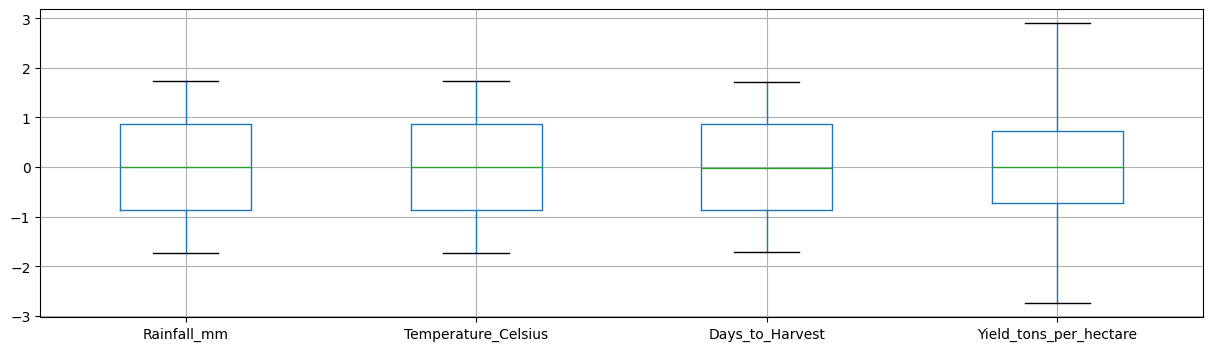

In [459]:
plt.figure(figsize=(15, 4))
df_crop_yield[['Rainfall_mm','Temperature_Celsius','Days_to_Harvest','Yield_tons_per_hectare']].boxplot()
plt.xticks(rotation=0)
plt.show()

### Random Sample and Balance Labels

In [460]:
df_crop_yield = df_crop_yield.sample(10000, random_state=42)
df_crop_yield

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
517655,-1.323994,-1.031876,True,True,1,0.520360,-0.390588,True,False,False,...,False,True,False,False,False,False,False,True,False,False
756521,0.171972,0.609267,False,True,1,0.250643,0.328831,False,False,False,...,False,False,False,False,False,False,False,False,True,False
655545,1.053462,-0.094079,False,True,1,-0.751160,1.009457,False,False,False,...,False,True,False,False,False,False,False,True,False,False
163503,-0.364239,1.172926,False,False,2,1.676287,-0.440961,True,False,False,...,False,False,False,False,False,False,False,True,False,False
138977,1.407222,1.071905,False,True,2,0.944200,1.073729,False,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366471,0.545313,0.120286,False,True,2,0.597422,0.625946,True,False,False,...,False,False,False,True,True,False,False,False,False,False
597303,1.421486,1.360510,True,True,0,-1.483247,2.382218,True,False,False,...,False,False,False,False,False,False,False,True,False,False
933086,-1.562849,1.049316,True,True,0,0.520360,-0.232247,False,True,False,...,False,False,False,False,False,False,False,True,False,False
704945,-0.717055,0.005245,False,False,0,-0.828222,-1.310048,False,False,True,...,False,False,False,True,True,False,False,False,False,False


In [461]:
df_non_negative = df_non_negative.loc[df_crop_yield.index]
df_non_negative

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
517655,206.094584,20.055304,True,True,1,118,3.988413,True,False,False,...,False,True,False,False,False,False,False,True,False,False
756521,594.744256,31.905080,False,True,1,111,5.207813,False,False,False,...,False,False,False,False,False,False,False,False,True,False
655545,823.753867,26.826612,False,True,1,85,6.361459,False,False,False,...,False,True,False,False,False,False,False,True,False,False
163503,455.437452,35.974947,False,False,2,148,3.903031,True,False,False,...,False,False,False,False,False,False,False,True,False,False
138977,915.660191,35.245533,False,True,2,129,6.470399,False,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366471,691.737757,28.374421,False,True,2,120,5.711415,True,False,False,...,False,False,False,True,True,False,False,False,False,False
597303,919.366141,37.329383,True,True,0,66,8.688260,True,False,False,...,False,False,False,False,False,False,False,True,False,False
933086,144.040308,35.082429,True,True,0,118,4.256797,False,True,False,...,False,False,False,False,False,False,False,True,False,False
704945,363.776363,27.543774,False,False,0,83,2.429946,False,False,True,...,False,False,False,True,True,False,False,False,False,False


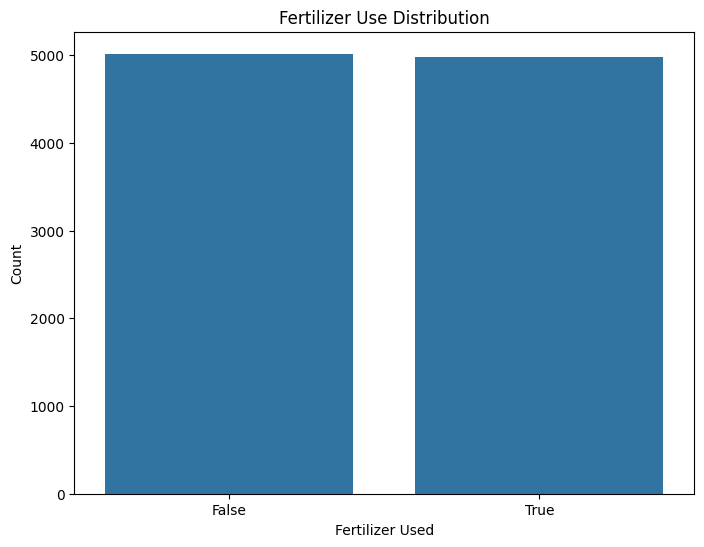

In [462]:
class_counts = df_crop_yield.Fertilizer_Used.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Fertilizer Use Distribution')
plt.xlabel('Fertilizer Used')
plt.ylabel('Count')
plt.show()

Target labels are fairly balanced, so we will leave it as is.

### Separate Target Labels

In [463]:
df_labels = df_crop_yield.Fertilizer_Used
df_crop_yield = df_crop_yield.drop(columns=['Fertilizer_Used'])

df_labels_nn = df_non_negative.Fertilizer_Used
df_non_negative = df_non_negative.drop(columns=['Fertilizer_Used'])

In [464]:
df_labels

517655     True
756521    False
655545    False
163503    False
138977    False
          ...  
366471    False
597303     True
933086     True
704945    False
499232    False
Name: Fertilizer_Used, Length: 10000, dtype: bool

In [465]:
# confirm labels were extracted and print unique target labels
print(sorted(df_labels.unique()))

[np.False_, np.True_]


In [466]:
# confirm that labels have been dropped
df_crop_yield

,Rainfall_mm,Temperature_Celsius,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,Region_West,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
517655,-1.323994,-1.031876,True,1,0.520360,-0.390588,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
756521,0.171972,0.609267,True,1,0.250643,0.328831,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
655545,1.053462,-0.094079,True,1,-0.751160,1.009457,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
163503,-0.364239,1.172926,False,2,1.676287,-0.440961,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
138977,1.407222,1.071905,True,2,0.944200,1.073729,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366471,0.545313,0.120286,True,2,0.597422,0.625946,True,False,False,False,...,False,False,False,True,True,False,False,False,False,False
597303,1.421486,1.360510,True,0,-1.483247,2.382218,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
933086,-1.562849,1.049316,True,0,0.520360,-0.232247,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
704945,-0.717055,0.005245,False,0,-0.828222,-1.310048,False,False,True,False,...,False,False,False,True,True,False,False,False,False,False


In [467]:
# Sanity Check 5: Check labels shape and (-)labels crop yield dataframe shape
assert df_labels.shape == (10000,), f"expected (10000,), but got {df_labels.shape}"
assert df_crop_yield.shape == (10000, 22), f"expected (10000, 22), but got {df_crop_yield.shape}"
tests_passed += 1
print ("5. Tests Passed")

5. Tests Passed


### Data Cleaning and EDA Conclusion

## Model Building and Training

### Split Data for Train and Validation Sets

Since we have a dense dataset, we will use a 70-30 train-validation split  

In [468]:
X_train, X_test, y_train, y_test = train_test_split(df_crop_yield, df_labels, test_size=0.3, random_state=42)

In [469]:
X_train_nmf = df_non_negative.loc[X_train.index]
X_test_nmf = df_non_negative.loc[X_test.index]
y_train_nmf = df_labels_nn.loc[y_train.index]
y_test_nmf = df_labels_nn.loc[y_test.index]

### Hierarchical Clustering

In [470]:
import itertools

unique_labels = sorted(list(y_train.unique()))

# Helper function from CSCA 5632 Week 2 Lab
def label_permute_compare(ytdf,yp,n=2):
    permutations = list(itertools.permutations(range(n)))
    
    max_acc = float('-inf')
    permutation_ = None
    prediction_ = None
    
    for permutation in permutations:
        cluster_to_index = np.take(permutation, yp)
        prediction = np.take(unique_labels, cluster_to_index)
        
        acc = sum(ytdf == prediction)/ytdf.shape[0]
        if acc > max_acc:
            max_acc = acc
            permutation_ = permutation
            prediction_ = prediction

    return permutation_, max_acc

In [471]:
model=AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
model.fit(X_train)
model.labels_

array([1, 1, 1, ..., 1, 0, 0])

In [472]:
labelorder, acc = label_permute_compare(y_train, model.labels_)
print(labelorder, acc)


(1, 0) 0.5547142857142857


In [473]:
cluster_to_index = np.take(labelorder, model.labels_)
prediction = np.take(unique_labels, cluster_to_index)
print(unique_labels, '\n')
print(confusion_matrix(np.array(y_train), prediction, labels=unique_labels))

[np.False_, np.True_] 

[[1734 1756]
 [1361 2149]]


In [474]:
metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

max_acc = float('-inf')
best_confusion_mat = None
best_metric = None
best_linkage = None

for metric_ in metrics:
    for linkage_ in linkages:
        if linkage_ == 'ward' and metric_ != 'euclidean':
            continue
            
        model=AgglomerativeClustering(n_clusters=2, metric=metric_, linkage=linkage_)
        model.fit(X_train)
        labelorder, acc = label_permute_compare(y_train, model.labels_)
        
        cluster_to_index = np.take(labelorder, model.labels_)
        prediction = np.take(unique_labels, cluster_to_index)
        best_confusion_mat = confusion_matrix(np.array(y_train), prediction, labels=unique_labels)
        
        if acc > max_acc:
            max_acc = acc
            confusion_mat = confusion_matrix_
            best_metric = metric_
            best_linkage = linkage_

In [475]:
print(max_acc, best_metric, best_linkage)

0.5708571428571428 l1 complete


### K-Means Clustering

In [492]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
model.fit(X_train)
print(model.labels_)

labelorder, acc = label_permute_compare(y_train, model.labels_)
print(labelorder, acc)

[0 0 0 ... 0 1 0]
(0, 1) 0.5674285714285714


In [493]:
prediction = model.predict(X_test)

labelorder, acc = label_permute_compare(y_test, prediction)
print(labelorder, acc)

(0, 1) 0.5726666666666667


In [494]:
from scipy import stats

# Calculate p-value assuming binomial probability distribution for n = |y_test|
p = 0.5
mean = p * len(y_test)
std = np.sqrt(len(y_test) * p * (1-p))
observed_accuracy = acc * len(y_test)

# Calculate the z-score
z_score = (observed_accuracy - mean) / std

# Calculate the p-value (two-tailed)
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

# Print results
print(f"Z-score: {z_score}")
print(f"P-value: {p_value}")

Z-score: 7.960234502408414
P-value: 1.7763568394002505e-15


### Spectral Clustering

In [480]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2, affinity='poly', random_state=42)
prediction = spectral.fit_predict(X_train)

labelorder, acc = label_permute_compare(y_train, prediction)
print(labelorder, acc)

(0, 1) 0.5685714285714286


In [481]:
unique_labels

[np.False_, np.True_]

In [482]:
cluster_to_index = np.take(labelorder, prediction)
prediction = np.take(unique_labels, cluster_to_index)
print(unique_labels, '\n')
print(confusion_matrix(np.array(y_train), prediction, labels=unique_labels))

# Construct confusion matrix
confusion_mat = confusion_matrix(y_train, prediction)

# Calculate Precision
_precision = precision(confusion_mat)
# Calculate Recall
_recall = recall(confusion_mat)

print(_precision, _recall)

[np.False_, np.True_] 

[[1885 1605]
 [1415 2095]]
0.5687141687141687 0.5684903550233062


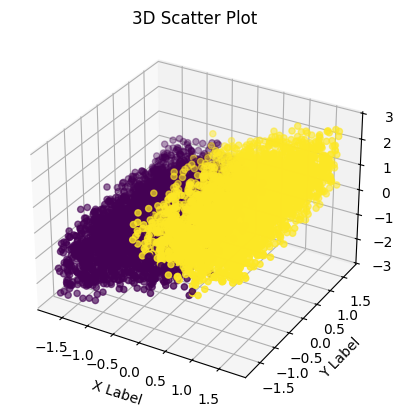

In [98]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['Rainfall_mm'], X_train['Temperature_Celsius'], X_train['Yield_tons_per_hectare'], c=prediction, marker='o')

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title("3D Scatter Plot")

plt.show()

In [99]:
X_train

,Rainfall_mm,Temperature_Celsius,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,Region_West,...,Soil_Type_Loam,Soil_Type_Peaty,Soil_Type_Sandy,Soil_Type_Silt,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
427183,-1.082566,1.641446,False,2,-0.096135,-0.534585,False,False,False,True,...,False,False,False,True,True,False,False,False,False,False
297573,-1.436393,1.491628,False,0,-1.598839,-1.581625,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
114607,-0.058117,-1.169283,True,2,1.406570,0.022212,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
203323,0.379661,1.231049,True,0,0.713014,0.983342,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
460926,-1.707636,-1.570497,True,2,1.599225,-1.038584,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69718,1.348326,-1.079722,True,0,-0.751160,0.990589,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
50656,0.993473,0.136322,True,0,-0.057604,0.957135,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
677445,0.018477,0.663037,True,2,0.828607,0.565809,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
989222,-0.737288,0.841675,False,0,0.674483,-1.809200,False,False,True,False,...,False,False,False,True,False,False,True,False,False,False


### Non-negative Matrix Factorization

In [496]:
from sklearn.decomposition import NMF
import itertools

In [497]:
nmf = NMF(n_components=2, 
          init='random',
          solver='mu',
          beta_loss='kullback-leibler',
          random_state = 42)
nmf_train = nmf.fit_transform(X_train_nmf)

yp = np.argmax(nmf_train, axis=1)
labelorder, acc = label_permute_compare(y_train_nmf, yp)
print(labelorder, acc)

(0, 1) 0.5062857142857143


In [499]:
nmf_test = nmf.transform(X_test_nmf)
yp_test = np.argmax(nmf_test, axis=1)

labelorder, acc = label_permute_compare(y_test_nmf, yp_test)
print(labelorder, acc)

(0, 1) 0.502


In [502]:
inits = [None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar', 'custom']
solvers = ['cd', 'mu']
beta_losses = ['frobenius', 'kullback-leibler', 'itakura-saito']

combinations = list(itertools.product(inits, solvers, beta_losses))

for init, solver, beta_loss in combinations:
    try:
        nmf = NMF(n_components=2,
                  init=init, 
                  solver = solver,
                  beta_loss = beta_loss,
                  random_state = 0)
        
        nmf_train = nmf.fit_transform(X_train_nmf)
        
        yp = np.argmax(nmf_train, axis=1)
        # print(np.unique(yp, return_counts=True))
        labelorder, acc = label_permute_compare(y_train_nmf, yp)
        print(init, solver, beta_loss)
        print(labelorder, acc, '\n')
    except:
        pass

None cd frobenius
(1, 0) 0.5014285714285714 

None mu frobenius
(1, 0) 0.5017142857142857 

None mu kullback-leibler
(0, 1) 0.5031428571428571 

random cd frobenius
(1, 0) 0.5041428571428571 

random mu frobenius
(0, 1) 0.5044285714285714 

random mu kullback-leibler
(1, 0) 0.5012857142857143 

nndsvd cd frobenius
(1, 0) 0.5005714285714286 

nndsvd mu frobenius
(0, 1) 0.5 

nndsvd mu kullback-leibler
(0, 1) 0.5001428571428571 

nndsvda cd frobenius
(1, 0) 0.5014285714285714 

nndsvda mu frobenius
(1, 0) 0.5017142857142857 

nndsvda mu kullback-leibler
(0, 1) 0.5031428571428571 

nndsvdar cd frobenius
(1, 0) 0.5008571428571429 

nndsvdar mu frobenius
(0, 1) 0.501 

nndsvdar mu kullback-leibler
(0, 1) 0.5001428571428571 



In [503]:
# Calculate p-value assuming binomial probability distribution for n = |y_test|
p = 0.5
mean = p * len(y_test) 
std = np.sqrt(len(y_test) * p * (1-p))
observed_accuracy = acc * len(y_test)

# Calculate the z-score
z_score = (observed_accuracy - mean) / std

# Calculate the p-value (two-tailed)
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

# Print results
print(f"Z-score: {z_score}")
print(f"P-value: {p_value}")

Z-score: 0.015649215928715474
P-value: 0.9875142418466694


### Linear Kernel SVC

In [353]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-10, 10, 301, base=2)}
svc = LinearSVC(random_state=42)
grid_linsvc = GridSearchCV(svc, parameters, cv=5, n_jobs=-1, scoring='accuracy')

grid_linsvc.fit(X_train, y_train)

best_params = grid_linsvc.best_params_
best_score = grid_linsvc.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")

best params: {'C': np.float64(35.09839935022802), 'loss': 'hinge'}
cross validation score: 0.9302857142857143


In [354]:
def handle_stats(predictor, model_name):
    
    # Predict validation set
    prediction = predictor.predict(X_test)
    test_labels = np.array(y_test)
    
    print(f"Prediction: {prediction} \n")
    print(f"True Label: {test_labels} \n")
    
    # Calculate Accuracy
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    accuracy = correct/total
    
    # Construct confusion matrix
    confusion_mat = confusion_matrix(test_labels, prediction)
    
    # Calculate Precision
    _precision = precision(confusion_mat)
    # Calculate Recall
    _recall = recall(confusion_mat)
    
    print(confusion_mat)
    print(f"accuracy: {accuracy}")
    print(f"precision: {_precision}")
    print(f"recall: {_recall}")

handle_stats(grid_linsvc.best_estimator_, 'Linear SVC')

Prediction: [ True  True  True ... False  True  True] 

True Label: [ True  True  True ... False  True False] 

[[1376  102]
 [  88 1434]]
accuracy: 0.9366666666666666
precision: 0.9367422301912569
recall: 0.9365845808609496


### Non-linear SVC

In [356]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel': ['rbf'],
              'C':np.logspace(-10, 10, 11, base=2),
              'gamma':np.logspace(-10, 10, 11, base=2)
             }
svc = SVC(random_state=0)
grid_svc_nonlin = GridSearchCV(svc, parameters, cv=5, n_jobs=-1, scoring='accuracy')

grid_svc_nonlin.fit(X_train, y_train)

best_params = grid_svc_nonlin.best_params_
best_score = grid_svc_nonlin.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")

best params: {'C': np.float64(256.0), 'gamma': np.float64(0.0009765625), 'kernel': 'rbf'}
cross validation score: 0.9288571428571428


In [357]:
handle_stats(grid_svc_nonlin.best_estimator_, 'Non-linear SVC')

Prediction: [ True  True  True ... False  True  True] 

True Label: [ True  True  True ... False  True False] 

[[1371  107]
 [  87 1435]]
accuracy: 0.9353333333333333
precision: 0.9354694080158845
recall: 0.9352216210064743


In [ ]:
assert tests_passed == num_tests, f"{tests_passed} out of {num_tests} tests passed. {num_tests-tests_passed} cases failed. Please check test cases."
print("All Tests Passed")